# **Loan Default Prediction**: *Model Training*
In the previous notebook, we trained our baseline model using the `LogisticRegression()` algorithm, despite this giving us a good result, it had its limitations, that being:
- Despite appying hyperparameter tuning using `RandomizedSearchCV`, the model had the same results.

This meant that the model had reached it's limits standing at an equal score of 69% for all the metrics and at 76% ROC-AUC curve.

In this notebook, we are going to pick it up from there and use `DecisionTreeClassifier()` and `RandomForestClassifier()` to boost our model performance. 

## **Data Preparation**
In this step we are importing all the necesarry packages, loading the cleaned data and splitting the data inti training and test datasets.

In [1]:
# Import important dependencies
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, roc_auc_score, make_scorer, f1_score, precision_recall_curve, average_precision_score

In [2]:
# Load the cleaned data
loans_info = pd.read_csv("../Data/CleanData/Cleaned_Loans_Data.csv")

# Preview
loans_info.head()

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


In [3]:
# Assign predictors and target variable to their respective variables.
X = loans_info.drop("Default", axis=1)
y = loans_info["Default"]

# Split the data into train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## **`DecisionTreeClassifier()`**
First, we are using the `DecisionTreeClassifier()` algorithm because:
- `DecisionTreeClassifier()` is considered better than `LogisticRegression()` in certain situations due to its ease in interpretation and ability to handle non-linear relationships and outliers. During our EDA, we noticed that the predictors had negative relationship with the target variable.

Before we start modeling, we are preprocessing the data, according to the needs of this specific algorithm, that is:
- No standardization

- Ordinal encoding the xcategorical data.

We are also applying the SMOTE for the class imbalance issue. 

In [4]:
# Copy train data
X_dt = X_train.copy()
y_dt = y_train.copy()

# Identify categorical columns
cat_cols = X_train.select_dtypes(include='object').columns

# Encode the categorical columns
encoder = OrdinalEncoder()
X_dt[cat_cols] = encoder.fit_transform(X_dt[cat_cols])

X_dt.head()

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner
15826,45,37039,247916,624,19,2,4.62,60,0.85,1.0,3.0,1.0,0.0,1.0,0.0,0.0
147371,48,133963,66275,494,119,3,14.72,48,0.49,3.0,2.0,1.0,1.0,1.0,4.0,1.0
178180,47,100204,6967,718,108,3,5.51,24,0.76,1.0,2.0,2.0,1.0,1.0,1.0,1.0
126915,42,36078,25966,344,2,3,18.29,36,0.76,0.0,2.0,1.0,0.0,1.0,2.0,0.0
163930,20,99464,248557,318,74,3,19.45,60,0.45,0.0,1.0,0.0,0.0,0.0,0.0,1.0


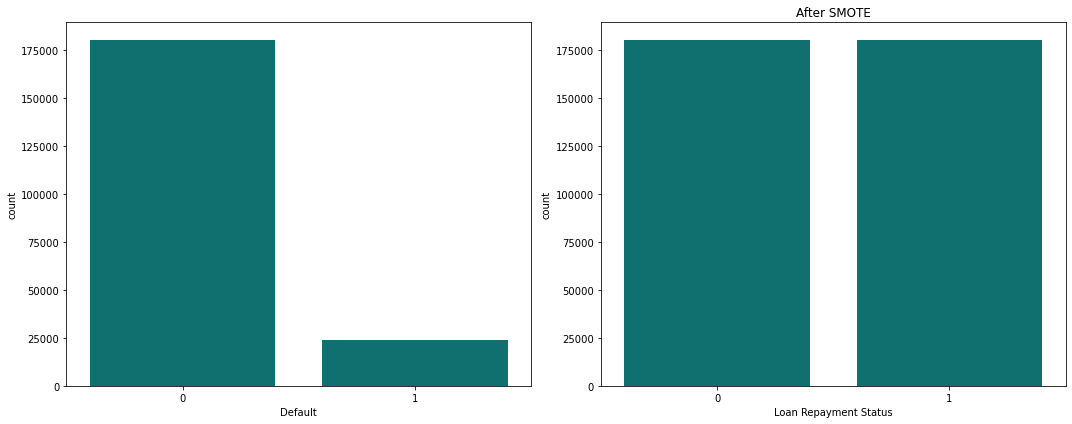

In [ ]:
# Apply SMOTE on the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_dt, y_dt)

# Create plot figure
fig, (ax1, ax2) = plt.subplots(figsize = (15, 6), ncols= 2)

# Plot ax1, before SMOTE
sns.countplot(x= y_dt, ax= ax1, color= 'teal')
plt.title('Before SMOTE')
plt.xlabel('Loan Repayment Status')

# Plot ax2, after SMOTE
sns.countplot(x= y_train_resampled, ax= ax2, color= 'teal')
plt.title('After SMOTE')
plt.xlabel('Loan Repayment Status')

plt.tight_layout()
plt.show()

### **Model 1: `DecisionTreeClassifier()` baseline model**
For our first model, we are setting the random state to 42 and fitting it on our resampled data.

In [6]:
# Train and fit the SMOTE model
dt = DecisionTreeClassifier(random_state=42).fit(X_train_resampled, y_train_resampled)

# Predict y
y_pred = dt.predict(X_train_resampled)

#### *Evaluation*

Baseline Model Evaluation:
              precision    recall  f1-score   support

     service       1.00      1.00      1.00    180555
     default       1.00      1.00      1.00    180555

    accuracy                           1.00    361110
   macro avg       1.00      1.00      1.00    361110
weighted avg       1.00      1.00      1.00    361110



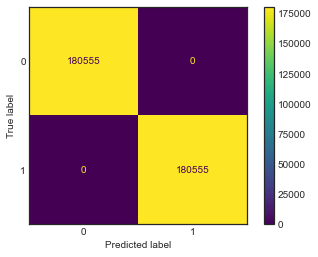

In [7]:
# Labels
class_label = ['service', 'default']

# Print model evaluation
print('Baseline Model Evaluation:')
print(classification_report(y_train_resampled, y_pred, target_names= class_label))

conf_matrix = confusion_matrix(y_train_resampled, y_pred)
plt.style.use('seaborn-white')
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot();

#### **Summary**
Our baseline model has an accuracy score of 100%, which is a clear indication of overfitting. This happened because Decision Trees are not regularized by default, therefore they split every branch till they memorize the whole dataset.

### **Model 2: Adding parameters**
In this model, we are adding some parameters to help boost it's performance. We are using:
- `max_depth`: to limit how deep the tree goes.

- `criterion` : to measure the quality of the split.

In [8]:
# Prepara data for training
X_dtree = X_train_resampled.copy()
y_dtree = y_train_resampled.copy()

# Train and fit the 'added parameters' model
dt = DecisionTreeClassifier(criterion= 'entropy', max_depth= 5, random_state= 42).fit(X_dtree, y_dtree)

# Predict y
y_pred = dt.predict(X_dtree)

#### *Evaluation*

Baseline Model Evaluation:
              precision    recall  f1-score   support

     service       0.73      1.00      0.85    180555
     default       1.00      0.64      0.78    180555

    accuracy                           0.82    361110
   macro avg       0.87      0.82      0.81    361110
weighted avg       0.87      0.82      0.81    361110



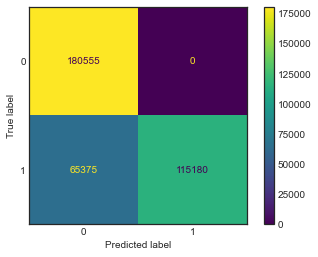

In [9]:
# Print model evaluation
print('Baseline Model Evaluation:')
print(classification_report(y_dtree, y_pred, target_names= class_label))

conf_matrix = confusion_matrix(y_dtree, y_pred)
plt.style.use('seaborn-white')
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot();

**Service**
- When it comes to the non_defaulters, the model favors recall over precision. Serviced loans has a precision score of 73% and a recall score of 100%.

- It also has an F1-score of 85%, indicating that the model is actually performing well when it come sto predicting the serviced loans.

**Default**
- The model favours precision over recall when it comes to predicting defaulters. It has a precision score of 100% and a recall score of 64%.

- This means that the model predicts defaulters correctly, but it’s only finding 64% of actual defaulters, the rest are slipping through.

#### **Summary**
- Overall, the model performs very well with an accuracy score of 82% and an F1-score of 81%. 

- The model best predicts the non-defaulters, with 100% precision. The confusion matrix indicates that the models identifies all the non-defaulters correctly.

- However, its not as successful when it comes to predicting defaulters, the model predicts over 60,000 defaulters as non-defaulters, which is a huge problem.

- The model is playing it safe, avoiding false positives by missing actual defaulters, which is not ideal for a loan product.

- Also, despite the great overall performance, the high performance might indicate overfitting and we have a huge number of defaulters identified as non-defaulters.

#### **CrossValidation**
This is to make sure the model is not overfitting.

In [10]:
f1 = make_scorer(f1_score, average='weighted')
f1_scores = cross_val_score(dt, X_dtree, y_dtree, cv=5, scoring=f1)
print("Cross-validated F1 scores:", f1_scores)
print("Average F1:", f1_scores.mean())

Cross-validated F1 scores: [0.57140019 0.86338544 0.8656345  0.86267242 0.86394076]
Average F1: 0.8054066627565624


- Standing at a high average of 0.805, this means the model generalizes well. However, one fold (Fold 1) did significantly worse, having an f1-score of 0.57.

- This means that the fold might have had fewer default cases (imbalanced split), or it might’ve been particularly noisy, or that the model might not generalize equally across all segments.

- With this in mind, we still have some room to improve generalization or handling of rare default cases.  To do this we are going to use staratified cross validation the next time we use it.

### **Model 3: Precision-Recall Curve**
In the previous model, we found that the model was actually missing actual defaulters, which is not ideal for our project. In this section we are trying to find the spot that ensures the model doesn't miss defaulters using precison-recall curve.

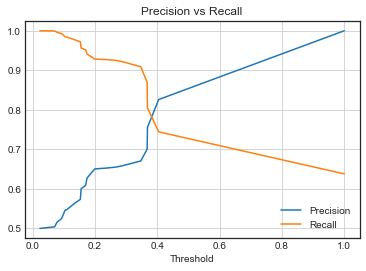

In [11]:
# 
y_proba = dt.predict_proba(X_dtree)[:, 1]

# 
precision, recall, thresholds = precision_recall_curve(y_dtree, y_proba)

# Plotting the curve
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Threshold")
plt.legend()
plt.title("Precision vs Recall")
plt.grid(True)
plt.show()

#### **Key Observations**
1. Recall is high when the threshold is low:

- We are identifying nearly all defaulters (high recall), but our precision tanks because we’re also flagging a lot of non-defaulters.

2. Precision increases as threshold increases:

- This is because we're becoming more conservative, only flagging as "default" when we're really sure,  but then we're missing many actual defaulters (low recall).

3. The plot indicates that the Crossover Point (around 0.38–0.40) is the sweet spot:

- Both precision and recall are around 75–80%. Making it our best trade-off:

In the next cell we are using the threshold of 0.39 to see how it works.

In [12]:
# Set threshold
threshold = 0.39
y_pred_thresh = (y_proba >= threshold).astype(int)

# Print evaluation metrics
print(classification_report(y_dtree, y_pred_thresh, target_names= class_label))

              precision    recall  f1-score   support

     service       0.77      0.84      0.80    180555
     default       0.83      0.74      0.78    180555

    accuracy                           0.79    361110
   macro avg       0.80      0.79      0.79    361110
weighted avg       0.80      0.79      0.79    361110



#### **Summary**
The threshold has balanced the false positives and negatives in both non defaulters and defaulters. But has dropped the accuracy score to 79%, which was expected.

### **Model 4: Hyperparameter Tuning using RandomizedSearchCV**
We have sorted all the problems we had in the previous models, now we are trying to boost the performance by using randomized search to find the best parameters.

In [13]:
# Define model
dt = DecisionTreeClassifier(criterion= 'entropy', random_state= 42)

# Define the hyperparameter grid
param_dist = {
    'min_samples_leaf': [5, 8, 10, 12], 
    'max_depth': [5, 7, 10, 13]
}

# Set up RandomizedSearchCV
rand_search = RandomizedSearchCV(estimator=dt, param_distributions=param_dist, 
                           cv=5, scoring='f1_macro', n_jobs=-1, verbose= 1)

# Fit to training data
rand_search.fit(X_dtree, y_dtree)

# Print best parameters
print("Best params:", rand_search.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.0min finished


Best params: {'min_samples_leaf': 8, 'max_depth': 13}


#### *Evaluation*
The `RandomizedSearchCV` has found `'min_samples_leaf': 5, 'max_depth': 13` as the best parameters for the model. Next we are finding the y_probability and using the threshold we found earlier to evaluate this model.

In [14]:
y_probs = rand_search.predict_proba(X_dtree)[:, 1]

# Step 3: Apply your custom threshold
threshold = 0.38  # your chosen threshold
y_pred_custom = (y_probs >= threshold).astype(int)

# Step 4: Evaluate the custom predictions
print(classification_report(y_dtree, y_pred_custom, target_names= class_label))

              precision    recall  f1-score   support

     service       0.86      0.95      0.90    180555
     default       0.94      0.85      0.89    180555

    accuracy                           0.90    361110
   macro avg       0.90      0.90      0.90    361110
weighted avg       0.90      0.90      0.90    361110



**Service**
- The model favors recall over precision, the recall score stands at 95% while precision score stands at 86%.

**Default**
- The model favors precision over reacll, meaning that the model correctly identifies 94% of the defaulters, which is good but 15% of them slip right through.

#### **Summary**
- The model performs well compared to all the previous models standing at 90% on all metrics.

- The balanced metric scores means that the model isn't favoring any metric at the expense of the other.

- However, such a high accuracy score could be an indication of overfitting.

#### **CrossValidation**
To make sure the model is not overfitting.

In [15]:
f1 = make_scorer(f1_score, average='weighted')
f1_scores = cross_val_score(rand_search, X_dtree, y_dtree, cv=5, scoring=f1)
print("Cross-validated F1 scores:", f1_scores)
print("Average F1:", f1_scores.mean())

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.6min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.9min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.6min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.4min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.4min finished


Cross-validated F1 scores: [0.62560302 0.94055041 0.94471574 0.94243122 0.94221758]
Average F1: 0.8791035922487183


The cross validated f1-score differs by about 3 points from the training model, which indicates that our model is not overfitting.

However, one of the folds performed worse than the others, which could mean that the splits were not stratified.

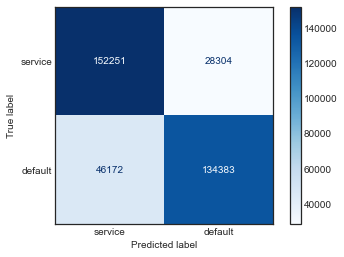

In [16]:
cm = confusion_matrix(y_dtree, y_pred_thresh)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= class_label)
disp.plot(cmap='Blues')

**Service**
- It has the most true positives and the lowest false negatives.

**Default**
- Has the lowest true positives and the highest false negatives.

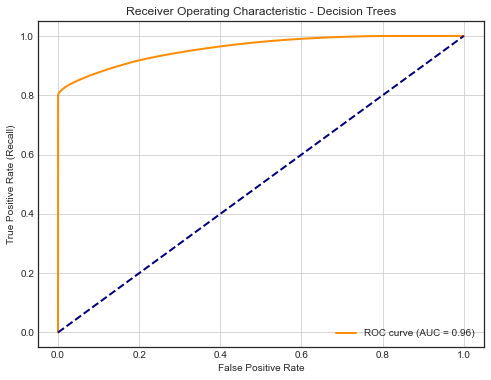

In [17]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_dtree, y_probs)
roc_auc = roc_auc_score(y_dtree, y_probs)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic - Decision Trees')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

- The plot above indicates that the model is excellent at distinguishing between defaulters and non-defaulters, no matter the threshold.

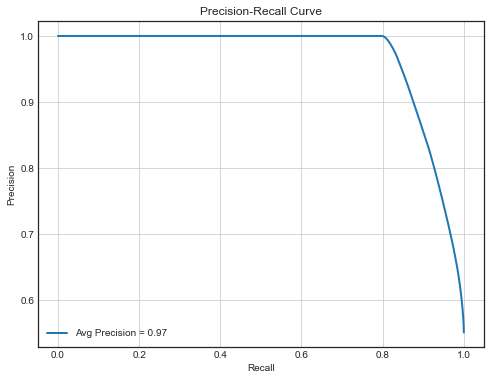

In [18]:
precision, recall, thresholds = precision_recall_curve(y_dtree, y_probs)
avg_precision = average_precision_score(y_dtree, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, lw=2, label=f'Avg Precision = {avg_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()


- Even across all possible thresholds, the plot shows that the model is maintaining exceptionally high precision when it's confident someone will default.

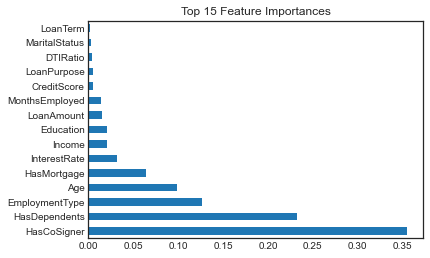

In [19]:
# RandomizedSearchCV doesn't support feature importance directly, we are using a base estimator to make the connection.
best_rf = rand_search.best_estimator_

feature_importances = pd.Series(best_rf.feature_importances_, index=X.columns)
feature_importances.nlargest(15).plot(kind='barh')
plt.title('Top 15 Feature Importances')
plt.show()

### **`DecisionTree` Summary**
In this section, we trained the data trying to get better results than the one we got from `LogisticRegression()`. The previous algorithm achieved a final training accuracy score of 69%.

From that model training, we learnt that the `class_weight=` class imbalance tool did not work well with our data and so we had to work with SMOTE. Here, we preprocessed our data per the requirements of the `DecisionTree`, that is, no need for standardization and the use of ordinal encoder instead of one hot encoder. We also applied SMOTE to teh data before training just to prepare it once. After which we began our training. Here is the recap:
- **Model 1: baseline model**: We used the data tailored to the algorithm's needs. This model achieved an accuracy score of 100%, which was a clear indication of overfitting. This happened because Decision Trees is not regularized by deafult, and we did not use any penal.

- **Model 2: Adding paramet**

## `RandomForestClassifier()`
Despite having achieved great results when using `DecisionTrees`, we are moving forward with `RandomForest`. This is because, with loan defaults rocking the finance sector in the country, it is crucial for the institutions to be really sure that the borrowers will repay the loans to curb the rising non-performing loans.

This specific algorithm will really help us boost our performance/accuracy by creating an ensemble of decision trees, training each on a slightly different subset of the data and with different feature subsets, and then aggregating their predictions.

Also, built to handle complex datasets more effectively, this will ensure our model works well with unseen data, given the complexity and the delicacy of the situation.

### **Model 1: `RandomForestClassifier()` baseline model**
As decision trees work closely similar to Random forests, we are using the same preprocessed data, non-standardized and ordinal encoded, from earlier. This is meant to give us a starting point when training with this algorithm.

In [20]:
# Prepara data for training
X_rf = X_train_resampled.copy()
y_rf = y_train_resampled.copy()

# Train and fit the 'added parameters' model
rf = RandomForestClassifier(random_state= 42).fit(X_rf, y_rf)

# Predict y
y_pred = rf.predict(X_rf)

#### *Evaluation*

Baseline Model Evaluation:
              precision    recall  f1-score   support

     service       1.00      1.00      1.00    180555
     default       1.00      1.00      1.00    180555

    accuracy                           1.00    361110
   macro avg       1.00      1.00      1.00    361110
weighted avg       1.00      1.00      1.00    361110



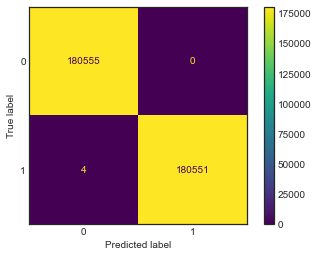

In [ ]:
# Print model evaluation
print('Baseline Model Evaluation:')
print(classification_report(y_rf, y_pred, target_names= class_label))

conf_matrix = confusion_matrix(y_rf, y_pred)
plt.style.use('seaborn-white')
disp = ConfusionMatrixDisplay(conf_matrix, display_labels= class_label)
disp.plot();

#### **Summary**
Without going any further, the model has memorized everything and is overfitting. In the next model, we are adding parameters to help prevent overfitting.

### **Model 2: Adding Parameters**
The previous model memorized the training data, which led to overfitting. Here we are adding parameters to ensure that the model is just going deep enough to learn the patterns but not deep to memorize the data.

We will be adding the following parameters:
- `max_depth`: Limits how deep the tree goes.

- `criterion`: Function used to measure the quality of the splits.

- `min_samples_leaf`: determines the minimum number of samples that a node leaf must have.

In [22]:
# Train and fit the 'added parameters' model
rf = RandomForestClassifier(criterion= 'entropy', max_depth= 10, min_samples_leaf= 5, random_state= 42).fit(X_rf, y_rf)

# Predict y
y_pred = rf.predict(X_rf)

#### *Evaluation*

Baseline Model Evaluation:
              precision    recall  f1-score   support

     service       0.86      0.99      0.92    180555
     default       0.99      0.83      0.91    180555

    accuracy                           0.91    361110
   macro avg       0.92      0.91      0.91    361110
weighted avg       0.92      0.91      0.91    361110



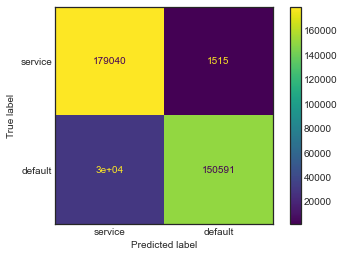

In [23]:
# Print model evaluation
print('Baseline Model Evaluation:')
print(classification_report(y_rf, y_pred, target_names= class_label))

conf_matrix = confusion_matrix(y_rf, y_pred)
plt.style.use('seaborn-white')
disp = ConfusionMatrixDisplay(conf_matrix, display_labels= class_label)
disp.plot();

**Service**
- This is the best prediction we have acheived yet, with the highest recall, but it could also mean that the model is overfitting.

- The model favours recall over precision at 99% and 86% respectively.

**Default**
- The model favors precision over recall when predicting defaulters.

#### **Summary**
- The over all model performance is excellent, with the accuracy score standing at 91%, and the f1-score also at 91%.

- The number of false positive/negative has also gone down, indicating that the model is identifying the classes more correctly than the previous models.

### **Model 3: Hyperparameter Tuning**
The previous model works well despite assumptions of overfitting. Before addressing those assumptions, we are tuning the model further, to come up with the best parameters before cross validating to nesure it is not overfitting. 

In [24]:
# Define model
rf = RandomForestClassifier(criterion='entropy', n_estimators= 100, random_state=42)

# Set parameters.
param_dist = {
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5],
    'class_weight': ['balanced']
}

# Serach for the best parameters
rand_search = RandomizedSearchCV(rf, param_distributions=param_dist,
                                 n_iter=20, cv=5, scoring='f1_macro', n_jobs=-1, verbose=1
)

# Fit the data on the model
rand_search.fit(X_rf, y_rf)

# Print best parameters
print("Best params:", rand_search.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 40.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 97.3min finished


Best params: {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20, 'class_weight': 'balanced'}


#### *Evaluation*
The randomized search has identified `'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20, 'class_weight': 'balanced'` as the best parameters. In the next cell, we are predicting using the said parameters and evealuating the model.

In [25]:
# Predict the train data.
y_pred = rand_search.predict(X_rf)

# Evaluate performance
print("Classification report:\n", classification_report(y_rf, y_pred, target_names= class_label))

Classification report:
               precision    recall  f1-score   support

     service       0.93      1.00      0.96    180555
     default       1.00      0.92      0.96    180555

    accuracy                           0.96    361110
   macro avg       0.96      0.96      0.96    361110
weighted avg       0.96      0.96      0.96    361110



#### **Summary**
- The model's over all performance performance is excellent, standing at an equal score of 96% for each metric.

- An accuracy score of 96% indicates that the model is doing well, however, it is also an indication that the model might be overfitting.

- In the next cell we are cross validating the model, just to be sure it is not memorizing the data and that it can generalize to unseen data.

#### **CrossValidation**

In [28]:
# Train and fit the 'added parameters' model
rf = RandomForestClassifier(criterion= 'entropy', min_samples_split= 2, min_samples_leaf= 1, max_depth= 20, class_weight= 'balanced', n_estimators= 100).fit(X_rf, y_rf)

# Predict y
y_pred = rf.predict(X_rf)

In [29]:
f1 = make_scorer(f1_score, average='weighted')
f1_scores = cross_val_score(rf, X_rf, y_rf, cv=5, scoring=f1)
print("Cross-validated F1 scores:", f1_scores)
print("Average F1:", f1_scores.mean())

Cross-validated F1 scores: [0.63000485 0.99303536 0.99285536 0.99292459 0.99338152]
Average F1: 0.9204403375993191


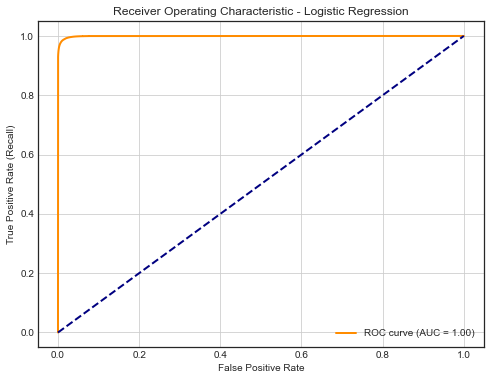

In [30]:
# Get predicted probabilities for the positive class
y_scores = rf.predict_proba(X_rf)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_rf, y_scores)
roc_auc = roc_auc_score(y_rf, y_scores)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic - Logistic Regression')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

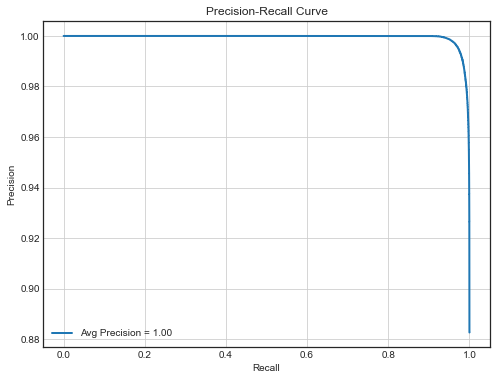

In [31]:
precision, recall, thresholds = precision_recall_curve(y_rf, y_scores)
avg_precision = average_precision_score(y_rf, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, lw=2, label=f'Avg Precision = {avg_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()


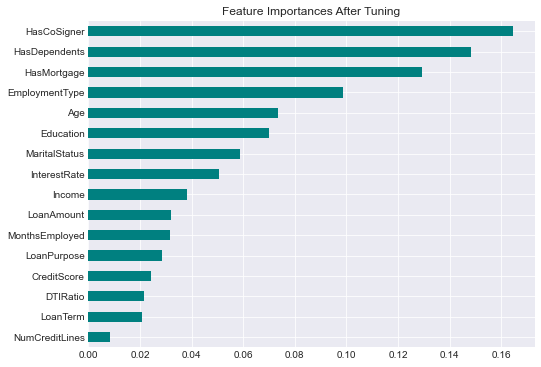

In [32]:
# Plot feature importances
plt.style.use('seaborn-darkgrid')
importances = pd.Series(rf.feature_importances_, index=X_rf.columns)
importances.sort_values(ascending=True).plot(kind='barh', figsize=(8, 6), color= 'teal')
plt.title("Feature Importances After Tuning")
plt.show()